# 第3章 TensorFlow基本开发步骤——以逻辑回归拟合二维数据为例

本章就直接将一个例子拿出来，在没有任何基础的前提下，一步一步实现一个简单的神经网络。通过这个实例来理解模型，并了解TensorFlow开发的基本步骤。

# 3.1 实例1：从一组看似混乱的数据中找出y≈2x的规律

本节通过一个简单的逻辑回归实例为读者展示深度学习的神奇。通过对代码的具体步骤，让读者对深度学习有一个直观的印象。

## 实例描述

假设有一组数据集，其x和y的对应关系为y≈2x。

本实例就是让神经网络学习这些样本，并能够找到其中的规律，即让神经网络能够总结出y≈2x这样的公式。

深度学习大概有如下4个步骤：

（1）准备数据。

（2）搭建模型。

（3）迭代训练。

（4）使用模型。

准备数据阶段一般就是把任务的相关数据收集起来，然后建立网络模型，通过一定的迭代训练让网络学习到收集来的数据特征，形成可用的模型，之后就是使用模型来为我们解决问题。

# 3.1.1 准备数据

这里使用y=2x这个公式来做主体，通过加入一些干扰噪声让它的“等号”变成“约等于”。
具体代码如下：
·导入头文件，然后生成-1～1之间的100个数作为x，见代码第1～5行。
·将x乘以2，再加上一个[-1，1]区间的随机数×0.3。即，y=2×x+a×0.3（a属于[-1，1]之间的随机数），见代码。

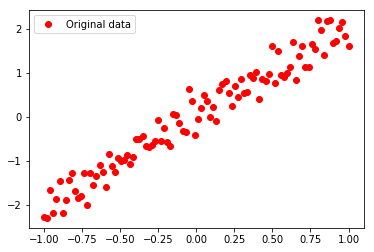

In [90]:
#代码3-1 线性回归
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plotdata = { "batchsize":[], "loss":[] }
def moving_average(a, w=10):    
    if len(a) < w:         
        return a[:]       
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]
train_X = np.linspace(-1, 1, 100)
train_Y = 2 * train_X + np.random.randn(*train_X.shape) * 0.3                # y=2x，但是加入了噪声
#显示模拟数据点
plt.plot(train_X, train_Y,'ro', label='Original data')
plt.legend()
plt.show()

注意：np.random.randn（*train_X.shape）这个代码如果看起来比较奇怪，现在给出解释—它等同于np.random. randn（100）

# 3.1.2 搭建模型

现在开始进行模型搭建。模型分为两个方向：正向和反向。

## 1．正向搭建模型

（1）了解模型及其公式在具体操作之前，先来了解一下模型的样子。神经网络是由多个神经元组成的，单个神经元的计算公式见式（3-1）

                                          z=w·x+b                                式（3-1）
 式中，z为输出的结果，x为输入，w为权重，b为偏执值。
 z的计算过程是将输入的x与其对应的w相乘，然后再把结果相加上偏执b。
 例如，有3个输入x1，x2，x3，分别对应w1，w2，w3，则，z=x1×w1+x2×w2+x3×w3+b。这一过程中，在线性代数中正好可以用两个矩阵来表示，于是就可以写成（矩阵W）×（矩阵X）+b。
 表明：形状为1行3列的矩阵与3行1列的矩阵相乘，结果的形状为1行1列的矩阵，即（1，3）×（3，1）=（1，1）
 
 注意：这里有个小窍门，如果想得到两个矩阵相乘后的形状，可以将第一个矩阵的行与第二个矩阵的列组合起来，就是相乘后的形状。
 在神经元中，w和b可以理解为两个变量。模型每次的“学习”都是调整w和b以得到一个更合适的值。最终，有这个值配合上运算公式所形成的逻辑就是神经网络的模型。
 
 （2）创建模型
 
 下面的代码演示了如何创建上述神经元网络模型。

In [66]:
#代码3-1 线性回归（续）
# 创建模型
# 占位符
X = tf.placeholder("float")
Y = tf.placeholder("float")
# 模型参数
W = tf.Variable(tf.random_normal([1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias")
# 前向结构
z = tf.multiply(X, W)+ b

下面解说一下代码。

（1）X和Y：为占位符，使用了placeholder函数进行定义。一个代表x的输入，一个代表对应的真实值y。占位符的意思后面再解释。

（2）W和b：就是前面说的参数。W被初始化成[-1，1]的随机数，形状为一维的数字，b的初始化为0，形状也是一维的数字。

（3）Variable：定义变量，在3.3节会有详细介绍。（4）tf.multiply：是两个数相乘的意思，结果再加上b就等于z了。

## 2．反向搭建模型

神经网络在训练的过程中数据的流向有两个方向，即先通过正向生成一个值，然后观察其与真实值的差距，再通过反向过程将里面的参数进行调整，接着再次正向生成预测值并与真实值进行比对，这样循环下去，直到将参数调整为合适值为止。

正向相对比较好理解，反向传播会引入一些算法来实现对参数的正确调整。

下面先看一下反向优化的相关代码。

In [67]:
#代码3-1 线性回归（续）
#反向优化
cost = tf.reduce_mean(tf.square(Y - z))
learning_rate = 0.01  
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)  #梯度下降

代码说明如下：

（1）cost，它等于生成值与真实值的平方差。

（2）learning_rate定义一个学习率，代表调整参数的速度。这个值一般是小于1的。这个值越大，表明调整的速度越大，但不精确；值越小，表明调整的精度越高，但速度慢。这就好比生物课上的显微镜调试，显微镜上有两个调节焦距的旋转钮，分为粗调和细调。

（3）GradientDescentOptimizer函数是一个封装好的梯度下降算法，里面的参数learning_rate叫做学习率，用来指定参数调节的速度。如果将“学习率”比作显微镜上不同档位的“调节钮”，那么梯度下降算法也可以理解成“显微镜筒”，它会按照学习参数的速度来改变显微镜上焦距的大小。

# 3.1.3 迭代训练模型

迭代训练的代码分成两步来完成：

## 1．训练模型

建立好模型后，可以通过迭代来训练模型了。TensorFlow中的任务是通过session来进行的。下面的代码中，先进行全局初始化，然后设置训练迭代的次数，启动session开始运行任务。

Epoch: 1 cost= 0.10708486 W= [1.772594] b= [0.09476724]
Epoch: 3 cost= 0.078208484 W= [1.9594] b= [0.04728403]
Epoch: 5 cost= 0.07509628 W= [2.0103354] b= [0.02814502]
Epoch: 7 cost= 0.07469622 W= [2.0235496] b= [0.02308109]
Epoch: 9 cost= 0.074620426 W= [2.026967] b= [0.0217697]
Epoch: 11 cost= 0.07460266 W= [2.0278516] b= [0.02143037]
Epoch: 13 cost= 0.074598186 W= [2.0280805] b= [0.02134257]
Epoch: 15 cost= 0.07459703 W= [2.02814] b= [0.02131969]
Epoch: 17 cost= 0.07459673 W= [2.0281556] b= [0.02131367]
Epoch: 19 cost= 0.07459666 W= [2.0281596] b= [0.02131213]
 Finished!
cost= 0.074596636 W= [2.0281603] b= [0.0213118]


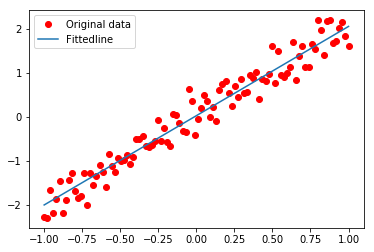

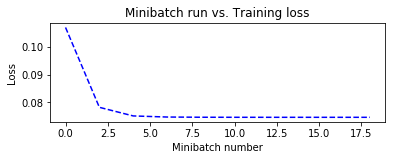

x=0.2，z= [0.42694387]


In [105]:
#代码3-1 线性回归（续）
#初始化所有变量
init = tf.global_variables_initializer()
#定义参数
training_epochs = 20
display_step = 2

#启动session
with tf.Session() as sess:
    sess.run(init)
    plotdata = { "batchsize":[], "loss":[] }             #存放批次值和损失值
    #向模型输入数据
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})
            
        #显示训练中的详细信息
        if epoch % display_step == 0:
            loss = sess.run(cost,feed_dict={X:train_X,Y:train_Y})
            print ("Epoch:", epoch+1,"cost=", loss,"W=", sess.run(W),"b=", sess.run(b))
            if not (loss == "NA" ):
                plotdata["batchsize"].append(epoch)
                plotdata["loss"].append(loss)
                    
    print (" Finished!")
## 训练模型可视化
#图形显示
    print ("cost=", sess.run(cost, feed_dict={X: train_X, Y: train_Y}),"W=", sess.run(W), "b=", sess.run(b))
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fittedline')
    plt.legend()
    plt.show()
    
    plotdata["avgloss"] = moving_average(plotdata["loss"])
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss')
    
    plt.show()
# 使用模型
    print ("x=0.2，z=", sess.run(z, feed_dict={X: 0.2}))

上面的代码中迭代次数设置为20次，通过sess.run来进行网络节点的运算，通过feed机制将真实数据灌到占位符对应的位置（feed_dict={X：x，Y： y}），同时，每执行一次都会将网络结构中的节点打印出来。

从代码运行结果可以看出，cost的值在不断地变小，W和b的值也在不断地调整。

## 2．训练模型可视化

上面的数值信息理解起来还是比较抽象。为了可以得到更直观的表达，下面将模型中的两个信息可视化出来，一个是生成的模型，另一个是训练中的状态值。具体代码已在上面描述。

这段代码中引入了一个变量和一个函数，已在代码的最顶端定义它们了。

现在所有的代码都准备好了，运行程序，生成如上图所示两幅图。

第一张图中所示的斜线，是模型中的参数w和b为常量所组成的关于x与y的直线方程。可以看到是一条几乎y=2x的直线（W接近于2，b接近于0）。

在第二张图中可以看到刚开始损失值一直在下降，直到5次左右趋近平稳。

# 3.1.4 使用模型

模型训练好后，用起来就比较容易了，往里面传一个0.2（通过feed_dict={X：0.2}），然后使用sess.run来运行模型中的z节点，见代码 print ("x=0.2，z=", sess.run(z, feed_dict={X: 0.2}))，看看它生成的x与z的值。

训练好的模型，可以根据已有数据的规律推算出输入值0.2对应的z值。

注意：读者在自己的计算机上运行该程序，得到的z值与书上的会不一样。这是因为b和w不一样。神经网络学习的是一种规律，能表示这一种规律的b和w会有很多值，即模型学出来的并非是唯一值。

# 3.2 模型是如何训练出来的

在上面的例子中仅仅迭代了20次就得到了一个可以拟合y≈2x的模型。下面来具体了解一下模型是如何得来的。

# 3.2.1 模型里的内容及意义

一个标准的模型结构分为输入、中间节点、输出三大部分，而如何让这三个部分连通起来学习规则并可以进行计算，则是框架TensorFlow所做的事情。

TensorFlow将中间节点及节点间的运算关系（OPS）定义在自己内部的一个“图”上，全通过一个“会话（session）”进行图中OPS的具体运算。

可以这样理解：

·“图”是静态的，无论做任何加、减、乘、除，它们只是将关系搭建在一起，不会有任何运算。

·“会话”是动态的，只有启动会话后才会将数据流向图中，并按照图中的关系运算，并将最终的结果从图中流出。

TensorFlow用这种方式分离了计算的定义和执行，“图”类似于施工图（blueprint），而“会话”更像施工地点。

构建一个完整的图一般需要定义3种变量。

·输入节点：即网络的入口。

·用于训练的模型参数（也叫学习参数）：是连接各个节点的路径。

·模型中的节点（OP）：最复杂的就是OP。OP可以用来代表模型中的中间节点，也可以代表最终的输出节点，是网络中的真正结构。

在实际训练中，通过动态的会话将图中的各个节点按照静态的规则运算起来，每一次的迭代都会对图中的学习参数进行更新调整，通过一定次数的迭代运算之后最终所形成的图便是所要的“模型”。而在会话中，任何一个节点都可以通过会话的run函数进行计算，得到该节点的真实数值。

# 3.2.2 模型内部的数据流向

模型内部的数据流向分为正向和反向。

## 1．正向

正向，是数据从输入开始，依次进行各节点定义的运算，一直运算到输出，是模型最基本的数据流向。它直观地表现了网络模型的结构，在模型的训练、测试、使用的场景中都会用到。这部分是必须要掌握的。

## 2．反向

反向，只有在训练场景下才会用到。这里使用了一个叫做反向链式求导的方法，即先从正向的最后一个节点开始，计算此时结果值与真实值的误差，这样会形成一个用学习参数表示误差的方程，然后对方程中的每个参数求导，得到其梯度修正值，同时反推出上一层的误差，这样就将该层节点的误差按照正向的相反方向传到上一层，并接着计算上一层的修正值，如此反复下去一步一步地进行转播，直到传到正向的第一个节点。
这部分原理TensorFlow已经实现好了，读者简单理解即可，应该把重点放在使用什么方法来计算误差，使用哪些梯度下降的优化方法，如何调节梯度下降中的参数（如学习率）问题上。

# 3.3 了解TensorFlow开发的基本步骤

通过上面的例子，现在将TensorFlow开发的基本步骤总结如下：

（1）定义TensorFlow输入节点。

（2）定义“学习参数”的变量。

（3）定义“运算”。

（4）优化函数，优化目标。

（5）初始化所有变量。

（6）迭代更新参数到最优解。

（7）测试模型。

（8）使用模型。

下面进行逐项介绍。

# 3.3.1 定义输入节点的方法

TensorFlow中有如下几种定义输入节点的方法。

通过占位符定义：一般使用这种方式。

·通过字典类型定义：一般用于输入比较多的情况。

·直接定义：一般很少使用。

本章开篇的第一个例子“3-1线性回归.py”就是通过占位符来定义输入节点的，具体使用了tf.placeholder函数，见如下代码。

In [106]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

下面介绍“通过字典定义”与“直接定义”的方法。

# 3.3.2 实例2：通过字典类型定义输入节点

# 实例描述

在代码“3-1线性回归.py”文件的基础上，使用字典占位符来代替用占位符定义的输入。
通过字典定义的方式和第一种比较像，只不过是堆叠到了一起。具体代码如下：

In [ ]:
#代码3-2 通过字典类型定义输出节点
......
# 占位符
inputdict = {'x': tf.placeholder("float"), 'y': tf.placeholder("float")}

# 3.3.3 实例3：直接定义输入节点

## 实例描述

在代码“3-1线性回归.py”文件的基础上，使用直接定义法来代替用占位符定义的输入。

直接定义，就是将定义好的Python变量直接放到OP节点中参与输入的运算，将模拟数据的变量直接放到模型中进行训练。代码如下：

In [ ]:
#代码3-3 直接定义输入节点
......
#生成模拟数据
train_X =np.float32( np.linspace(-1, 1, 100))
train_Y = 2 * train_X + np.random.randn(*train_X.shape) * 0.3 # y=2x，但是加入了噪声
#图形显示
plt.plot(train_X, train_Y, 'ro', label='Original data')
plt.legend()plt.show()

# 模型参数
W = tf.Variable(tf.random_normal([1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias")
# 前向结构
z = tf.multiply(W, train_X)+ b

提示：上面只列出了3种方法中的关键代码，全部的代码在本书的配套代码可以中找到。

# 3.3.4 定义“学习参数”的变量

学习参数的定义与输入的定义很像，分为直接定义和字典定义两部分。这两种都是常见的使用方式，只不过在深层神经网络里由于参数过多，普遍都会使用第二种情况。

在前面“3-1线性回归.py”的例子中使用的就是第一种方法，通过tf.Variable可以对参数直接定义。代码如下：

In [ ]:
# 模型参数
W = tf.Variable(tf.random_normal([1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias")

下面通过例子演示使用字典定义学习参数。

# 3.3.5 实例4：通过字典类型定义“学习参数”

## 实例描述

在代码“3-1线性回归.py”文件的基础上，使用字典的方式来定义学习参数。

通过字典的方式定义和直接定义比较相似，只不过是堆叠到了一起。修改“3-1线性回归.py”例子代码如下。

In [ ]:
#代码3-4 通过字典类型定义学习参数
......
# 模型参数
paradict = {'w': tf.Variable(tf.random_normal([1])),'b': tf.Variable(tf.zeros([1]))}
# 前向结构
z = tf.multiply(X, paradict['w'])+ paradict['b']

上面代码同样只是列出了关键部分，全部的代码都可以在本书的配套代码中找到。

# 3.3.6 定义“运算”

定义“运算”的过程是建立模型的核心过程，直接决定了模型的拟合效果，具体的代码演示在前面也介绍过了。这里主要阐述一下定义运算的类型，以及其在深度学习中的作用。

## 1．定义正向传播模型

在前面“3-1线性回归.py”的例子中使用的网络结构很简单，只有一个神经元。在后面会学到多层神经网络、卷积神经网、循环神经网络及更深层的GoogLeNet、Resnet等，它们都是由神经元以不同的组合方式组成的网络结构，而且每年还会有很多更高效且拟合性更强的新结构诞生。

## 2．定义损失函数

损失函数主要是计算“输出值”与“目标值”之间的误差，是配合反向传播使用的。为了在反向传播中可以找到最小值，要求该函数必须是可导的。
提示：损失函数近几年来没有太大变化。读者只需要记住常用的几种，并能够了解内部原理就可以了，不需要掌握太多细节，因为TensorFlow框架已经为我们做好了。

# 3.3.7 优化函数，优化目标

在有了正向结构和损失函数后，就是通过优化函数来优化学习参数了，这个过程也是在反向传播中完成的。

反向传播过程，就是沿着正向传播的结构向相反方向将误差传递过去。这里面涉及的技术比较多，如L1、L2正则化、冲量调节、学习率自适应、adm随机梯度下降算法等，每一个技巧都代表一个时代。

提示：随着深度学习的飞速发展，反向传播过程的技术会达到一定程度的瓶颈，更新并不如网络结构变化得那么快，所以读者也只需将常用的几种记住即可。

# 3.3.8 初始化所有变量

初始化所有变量的过程，虽然只有一句代码，但也是一个关键环节，所以特意将其列出来。

在session创建好了之后，第一件事就是需要初始化。还以“3-1线性回归.py”举例，代码如下：

In [ ]:
init = tf.global_variables_initializer()
# 启动Session
with tf.Session() as sess:    
    sess.run(init)

注意：使用tf.global_variables_initializer函数初始化所有变量的步骤，必须在所有变量和OP定义完成之后。这样才能保证定义的内容有效，否则，初始化之后定义的变量和OP都无法使用session中的run来进行算值。

# 3.3.9 迭代更新参数到最优解

在迭代训练环节，都是需要通过建立一个session来完成的，常用的是使用with语法，可以在session结束后自行关闭，当然还有其他方法，第4章会详细介绍。

In [ ]:
with tf.Session() as sess:

前面说过，在session中通过run来运算模型中的节点，在训练环节也是如此，只不过run里面放的是优化操作的OP，同时会在外层加上循环次数。

In [ ]:
for epoch in range(training_epochs):        
    for (x, y) in zip(train_X, train_Y):            
        sess.run(optimizer, feed_dict={X: x, Y: y})

真正使用过程中会引入一个叫做MINIBATCH概念进行迭代训练，即每次取一定量的数据同时放到网络里进行训练，这样做的好处和意义会在后面详细介绍。

# 3.3.10 测试模型

测试模型部分已经不是神经网络的核心环节了，同归对评估节点的输出，得到模型的准确率（或错误率）从而来描述模型的好坏，这部分很简单没有太多的技术，在“3-1线性回归.py”中可以找到如下代码：

In [ ]:
print ("cost=", sess.run(cost, feed_dict={X: train_X, Y: train_Y}), "W=", sess.run(W), "b=", sess.run(b))

当然这句话还可以改写成以下这样：

In [ ]:
print ("cost:",cost.eval({X: train_X, Y: train_Y}))

# 3.3.11 使用模型

使用模型也与测试模型类似，只不过是将损失值的节点换成输出的节点即可。在“3-1线性回归.py”例子中也有介绍。

这里要说的是，一般会把生成的模型保存起来，再通过载入已有的模型来进行实际的使用。关于模型的载入和读取，后面章节会有介绍。